In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import convolve
from scipy.signal import convolve2d


%matplotlib inline

In [15]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

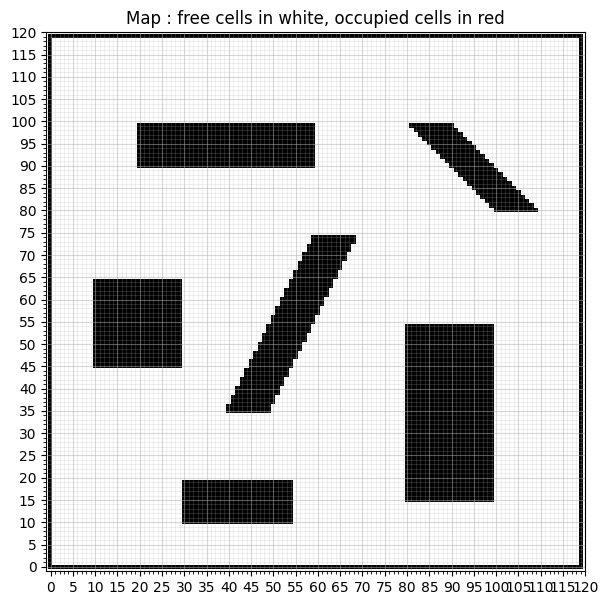

In [60]:
#Creating the grid
max_val = 120 # Size of the map

fig, ax = create_empty_plot(max_val)

# Creating the occupancy grid

data = np.zeros((max_val,max_val)) # Create an empty grid, with larger dimaensions than max_value to allow the convolution
for i in range(max_val): #Border
    data[i,0]=1
    data[i,max_val-1]=1
    data[0,i]=1
    data[max_val-1,i]=1

for j in range(10):        #Obstacles
    for k in range (20):
        data[40+j+k,35+2*k]=1
        data[40+j+k,36+2*k]=1

for j in range(25):
    for k in range (10):
        data[30+j,10+k]=1

for j in range(40):
    for k in range (10):
        data[20+j,90+k]=1

for j in range(20):
    for k in range (20):
        data[10+j,45+k]=1

for j in range(20):
    for k in range (40):
        data[80+j,15+k]=1

for j in range(10):        #Obstacles
    for k in range (20):
        data[100+j-k,80+k]=1


cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


In [61]:
def convolution_map(grid):
    """
    This function convolves the map of the environment with the circle in which lies the robot. 
    This way, it prevent the robot from getting too close to the obstacles
    :param grid: This is the gridded map of the environment
    :return: A convoluted map which has its obstacles made larger
    """
#Create the mask, its approximatively the circle in which the thymio can lie without tuching the border
    mask=np.ones((11,11))
    mask[0,0]=0
    mask[0,1]=0
    mask[1,0]=0
    mask[0,10]=0
    mask[1,10]=0
    mask[0,9]=0
    mask[10,0]=0
    mask[10,1]=0
    mask[9,0]=0
    mask[10,10]=0
    mask[9,10]=0
    mask[10,9]=0

    convolved_grid=convolve2d(grid, mask,mode='same') #make the convolution between the grid and the mask,
    
    limit = 0
    convolved_grid[convolved_grid>limit] = 1
    convolved_grid[convolved_grid<=limit] = 0

    return convolved_grid



In [62]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [162]:
def Key(current):
    """
    The key is used to prioritize nodes in the priority queue. It gives an idea on which is the next best node to explore
    :param s: current node (x,y)
    :return: Key of the node. Based on the gScore, the rhs, the heuristic and the key modifier km
    """
    current=tuple(current)
    Key_s=((min(gScore[current], rhs[current])) + h(current,start) + km, min(gScore[current], rhs[current]))
    Key_s=tuple(Key_s)
    return Key_s

def h(current_node,start_node):
    """
    The heuristic functiton. Here it is the euclidean distance from the start_node to the current_node, ignoring obstacles
    :param current_node: current node (x,y)
    :param start_node: starting node
    :return: Euclidean distance between start node and current node
    """
    current_node = np.array(current_node)
    start_node = np.array(start_node)
    return np.linalg.norm(current_node - start_node, axis=-1)
    
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.append(cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def D_Star_lite(start, goal, coords, occupancy_grid, movement_type="4N", max_val=max_val):
    """
    D*Lite for 2D occupancy grid. Finds a path from start to goal and can efficiently handle obstacle changes.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal: goal node (x, y)
    :param coords: set of all coordinates of the grid
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that no longer need to be expanded.
    global closedSet
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    global cameFrom
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n knowing the initial states of the research.
    global gScore
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[goal] = 0

    # Right hand side. Rhs[n] is the theoretical cheapest path from start to n given the current state of the search and the environment changes
    global rhs
    rhs = dict(zip(coords, [np.inf for x in range(len(coords))]))
    rhs[goal] = 0

    global km # Km stands for "key modifier". It corrects the heuristic function when recomputing new optimal path
    km=0

     # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the goal node is known (in contrary to the A* algorithm)
    # This set is also refered to as the "priority queue" or simply the "queue"
    global openSet
    openSet = dict(zip([(goal)],Key(goal)))

    # The D*Lite algorithm starts it research from the goal back to the start
     #This is because the goal stays the same whereas the start node changes each time the robot moves. 
    current=goal

    # while there are still elements to investigate
    while openSet != {}:

        
        #the node in openSet having the lowest Key[] value (it replaces the f function of the A* algorithm)
        current=min(openSet,key=openSet.get)
        
        #If the start is reached from the goal, reconstruct and return the obtained path
        if current == start:
            return reconstruct_path(cameFrom, current), closedSet
    
        # When we choose the current node, we have to dequeue it (remove from openSet) and update its gScore to be equal to the rhs value
        # Thus, the current shortest path "g" is equal to the theoretical shortest path "rhs"
        openSet.pop(current)
        gScore[current]=rhs[current]
        closedSet.append(current)

        #for each valid neighbor of current, put them in openSet compute the rhs value of neighbor: this will help tell which node to chose next
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has its gScore value updated (i.e. equal to rhs), skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (gScore[neighbor] == rhs[neighbor] <1000):
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_rhs is the theoretical cost from goal to the neighbor through current
            tentative_rhs = gScore[current] + deltacost

            if tentative_rhs < rhs[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                rhs[neighbor] = tentative_rhs

            # If the gScore is different form the rhs, this means that the node is inconsistent (
             # The current shortest path "g" is not equal to theoretical shortest path "rhs")
             # As the node is inconsistent, it goes in the queue (openSet)
            if gScore[neighbor] != rhs[neighbor]:
                openSet[neighbor]=Key(neighbor)
        

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

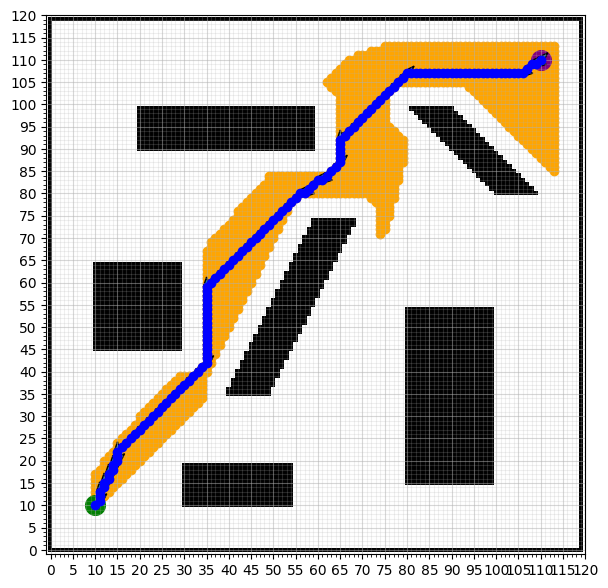

In [163]:
# Define the start and end goal
start = (10,10)
goal = (110,110)
global_start=start 


# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])



# Run the A* algorithm
occupancy_grid_conv=convolution_map(occupancy_grid)
path, visitedNodes = D_Star_lite(global_start, goal, coords, occupancy_grid_conv, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(global_start[0], global_start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
for i in range(len(path[0])-1):
    plt.arrow(path[0,i], path[1,i], path[0,i+1]-path[0,i], path[1,i+1]-path[1,i], width=0.5)

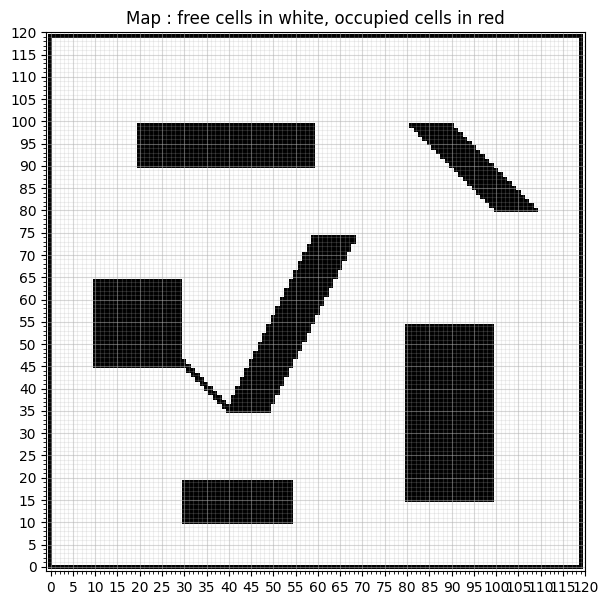

In [164]:
# Simulate a change in the map

fig, ax = create_empty_plot(max_val)

# Creating the occupancy grid

data_sim = data.copy()


for j in range(10):        #Obstacle at the beginning
    for k in range (2):
        data_sim[30+j,45+k-j]=1
"""

for k in range(7):         #Obstacle at the end
    data_sim[80,100+k]=1
"""

cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid_sim = data_sim.copy()
occupancy_grid_sim[data_sim>limit] = 1
occupancy_grid_sim[data_sim<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid_sim.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


In [165]:
def neighborhood(s):
    return [((s[0]-1),(s[1]+1)),((s[0]),(s[1]+1)),((s[0]+1),(s[1]+1)),((s[0]-1),(s[1])),(s),((s[0]+1),(s[1])),((s[0]-1),(s[1]-1)),((s[0]),(s[1]-1)),((s[0]+1),(s[1]-1))]

def A_Star(new_start, goal, coords, occupancy_grid_mod, km, movement_type="4N", max_val=max_val):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid_mod: the modified grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [new_start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid_mod[new_start[0], new_start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid_mod[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    closedSetIter=[]
    
    modified_nodes=[]
    for i in range(len(coords)):    
        if (occupancy_grid_mod[coords[i]]-occupancy_grid_conv[coords[i]]):
            current=coords[i]
            rhs[current]=np.inf
            openSet[current] = Key(current)
            modified_nodes.append(current)


    for (i,j) in modified_nodes:
        for dx, dy, deltacost in movements:
            neighbor = (i+dx, j+dy)
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid_mod.shape[0]) or (neighbor[1] >= occupancy_grid_mod.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                    continue
            # if the node is occupied or has already been visited, skip
            #if (occupancy_grid_mod[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
            if (occupancy_grid_mod[neighbor[0], neighbor[1]]): 
                    continue
            if neighbor not in openSet:
                openSet[neighbor]=Key(neighbor)

    


    # while there are still elements to investigate
    while openSet != {}:
        #the node in openSet having the lowest Key[] value     
        current=min(openSet,key=openSet.get)
        
        openSet.pop(current)

        
        if gScore[current] >= rhs[current]:
            gScore[current]=rhs[current]
            closedSetIter.append(current)
        else: #gScore[current] < rhs[current]:
            gScore[current]=np.inf
            openSet[current]=Key(current)
            for dx, dy, deltacost in movements:
                neighbor = (current[0]+dx, current[1]+dy)
                # if the node is not in the map, skip
                if (neighbor[0] >= occupancy_grid_mod.shape[0]) or (neighbor[1] >= occupancy_grid_mod.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                    continue
                # if the node is occupied or has already been visited, skip
                if (occupancy_grid_conv[neighbor[0], neighbor[1]]): #or (gScore[neighbor] == rhs[neighbor]<1000.0): 
                    continue
                if cameFrom[neighbor]==current:
                    rhs[neighbor] = np.inf

        
        #If the goal is reached, reconstruct and return the obtained path
        if gScore[new_start]==rhs[new_start]<1000:# and current == new_start :
            neighborhood_g=[]
            neighborhood_rhs=[]
            for (i,j) in neighborhood(new_start):
                neighborhood_g.append(gScore[i,j])
                neighborhood_rhs.append(rhs[i,j])
            if neighborhood_g==neighborhood_rhs:
                print("path found !")
                return reconstruct_path(cameFrom, new_start), closedSetIter
            del neighborhood_g,neighborhood_rhs



        #for each neighbor of current, put them in openSet compute the rhs value of neighbor: this will help tell which node to chose next
        for dx, dy, deltacost in movements:
            neighbor = (current[0]+dx, current[1]+dy)
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid_mod.shape[0]) or (neighbor[1] >= occupancy_grid_mod.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid_conv[neighbor[0], neighbor[1]]): #or (gScore[neighbor] == rhs[neighbor]<1000.0): 
                continue
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_rhs = gScore[current] + deltacost
            if neighbor in cameFrom:
                if occupancy_grid_mod[cameFrom[neighbor]]:
                    rhs[neighbor]=np.inf
            if (occupancy_grid_mod[neighbor]):
                tentative_rhs=np.inf
            if tentative_rhs < rhs[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                rhs[neighbor] = tentative_rhs
            if gScore[neighbor] != rhs[neighbor]:
                openSet[neighbor]=Key(neighbor)


        
            
        #print(current,Key(current),cameFrom[current])
        #print(openSet)
    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSetIter

path found !


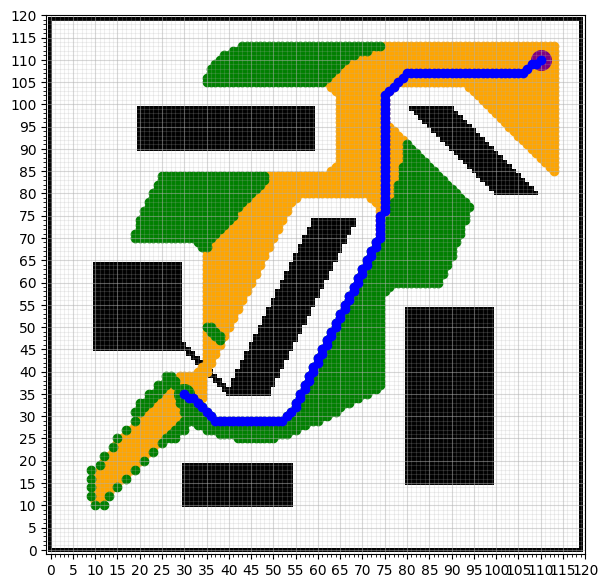

In [166]:
start = (30,35)
goal = (110,110)
km=h(start,global_start)

# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

###### Define the heuristic, here = distance to goal ignoring obstacles
###h = np.linalg.norm(pos - goal, axis=-1)
###h = dict(zip(coords, h))

# Run the A* algorithm
occupancy_grid_sim_conv=convolution_map(occupancy_grid_sim)
path, visitedNodesIter = A_Star(start, goal, coords, occupancy_grid_sim_conv, km, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodesIter = np.array(visitedNodesIter).reshape(-1, 2).transpose()


fig_astar, ax_astar = create_empty_plot(max_val)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.scatter(visitedNodesIter[0], visitedNodesIter[1], marker="o", color = 'green');

# Displaying the map
ax_astar.imshow(occupancy_grid_sim.transpose(), cmap=cmap)

ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
for i in range(len(path[0])-1):
    plt.arrow(path[0,i], path[1,i], path[0,i+1]-path[0,i], path[1,i+1]-path[1,i], width=0.1)

#print(VecteurVitesse(path))

In [108]:
Key((85,110))

(inf, inf)